### 1. the Dataset

The dataset is from [Airbnb wesite](http://insideairbnb.com/get-the-data.html) where they release data of various places around the world over time. The dataset used in this project was made public by Airbnb on April 17, 2019 and the city was Beijing, China.
* The dataset used is listings_detail, which includes 106 features and 28,452 records.
* The dataset contains the basic information of the listings, including the source of the listings, the landlord, price and reviews. After selection, we filtered out some features and are left with 46 features, the landlord(service, credibility, the type of the landlord), the proporty(available times, location and pricing,etc) and the tenant(reviews etc).

### 2. data preprocessing

#### 2.1 data preparation

In [7]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator
import seaborn as sns
import pandas_profiling
import missingno as msno
import datetime
import re
import os

In [8]:
detail = pd.read_csv('listings_detail.csv')
data_save = detail.iloc[:,[0,19,22,25,26,28,32,34,35,36,39,48,49,50,51,52,53,
                       54,55,56,57,58,60,63,64,65,66,67,68,75,80,82,83,84,
                       85,86,87,88,89,90,91,92,96,98,105]]

c:\users\wensh\pycharmprojects\dataanalysis\venv\lib\site-packages\IPython\core\interactiveshell.py:3147: DtypeWarning: Columns (43,61,62,95) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
# calculate the reservaion rate based on calendar_details
calendar = pd.read_csv('calendar_detail.csv')
calendar_f =  pd.DataFrame(calendar.loc[(calendar['available'] == 'f')].groupby(by=['listing_id'])['date'].count())
calendar_t = pd.DataFrame(calendar.loc[(calendar['available'] == 't')].groupby(by=['listing_id'])['date'].count())
calendar_count = pd.DataFrame(calendar.groupby(by = ['listing_id'])['date'].count())
rating = calendar_f / calendar_count
data1 = pd.merge(data_save, rating, how = 'left', left_on = 'id', right_index = True)
data1.rename(columns = {'date':'rating'}, inplace = True)
data1.to_csv('data1.csv',index = False)
print("variables：", data1.columns.values)

variables： ['id' 'host_id' 'host_since' 'host_response_time' 'host_response_rate'
 'host_is_superhost' 'host_listings_count' 'host_verifications'
 'host_has_profile_pic' 'host_identity_verified' 'neighbourhood_cleansed'
 'latitude' 'longitude' 'is_location_exact' 'property_type' 'room_type'
 'accommodates' 'bathrooms' 'bedrooms' 'beds' 'bed_type' 'amenities'
 'price' 'security_deposit' 'cleaning_fee' 'guests_included'
 'extra_people' 'minimum_nights' 'maximum_nights' 'calendar_updated'
 'availability_365' 'number_of_reviews' 'number_of_reviews_ltm'
 'first_review' 'last_review' 'review_scores_rating'
 'review_scores_accuracy' 'review_scores_cleanliness'
 'review_scores_checkin' 'review_scores_communication'
 'review_scores_location' 'review_scores_value' 'instant_bookable'
 'cancellation_policy' 'reviews_per_month' 'rating']


#### 2.2 data processing

In [10]:
# 1. features：'security_deposit'&'cleaning_fee'fill na，convert currency symbols
data1 = pd.read_csv("data1.csv")
data1.loc[:5, ['security_deposit', 'cleaning_fee']]
## fill na
data1['security_deposit'] = data1['security_deposit'].fillna(0)
data1['cleaning_fee'] = data1['cleaning_fee'].fillna(0)
##currency symbol conversion
for index, row in data1.iterrows():
    a = getattr(row, 'security_deposit')
    b = getattr(row, 'cleaning_fee')
    if type(a) == str:
        a = float(re.sub('[$,]', '', a))
        data1.loc[index, 'security_deposit'] = a
    if type(b) == str:
        b = float(re.sub('[$,]', '', b))
        data1.loc[index, 'cleaning_fee'] = b

In [11]:
# 2. 'neighbourhood_cleansed' language conversion
data2 = data1.copy()
data2.loc[:5, 'neighbourhood_cleansed']
rep = {'朝阳区 / Chaoyang':'Chaoyang', '东城区':'Dongcheng', '海淀区':'Haidian',   
       '丰台区 / Fengtai':'Fengtai', '西城区':'Xicheng', '通州区 / Tongzhou':'Tongzhou',
       '昌平区':'Changping', '密云县 / Miyun':'Miyun', '顺义区 / Shunyi':'Shunyi',
       '怀柔区 / Huairou':'Huairou', '大兴区 / Daxing':'Daxing', '延庆县 / Yanqing':'Yanqing',
       '房山区':'Fangshan', '石景山区':'Shijing', '门头沟区 / Mentougou':'Mentougou', '平谷区 / Pinggu':'Pinggu'}

rep = dict((re.escape(k), v) for k, v in rep.items())
pattern = re.compile("|".join(rep.keys()))
for index, row in data2.iterrows():
    a = getattr(row, 'neighbourhood_cleansed')
    my_str = pattern.sub(lambda m: rep[re.escape(m.group(0))], a)
    data2.loc[index, 'neighbourhood_cleansed'] = my_str
data2.loc[:5, 'neighbourhood_cleansed']

0     Chaoyang
1        Miyun
2    Dongcheng
3    Dongcheng
4     Chaoyang
5    Dongcheng
Name: neighbourhood_cleansed, dtype: object

In [16]:
# 3. column'host_since' convert to the number of day tto the date the data was collected(2019-04-17)
data3 = data2.copy()
now = '2019-04-17'
data3.iloc[:, 2] = data3.iloc[:, 2].apply(lambda x: int((datetime.datetime.strptime(now, '%Y-%m-%d')- datetime.datetime.strptime(x, '%Y-%m-%d')).days))

In [17]:
# 4. deal with column 'host_response_time'&'host_response_rate' missing values
# column'host_response_time'if missing, then get a new category “no body cares”
# column 'host_response_rate' convert % to float
# column 'host_response_rate'if missing, then replace with the mean

data4 = data3.copy()
data4.loc[:5, ['host_response_time', 'host_response_rate']]
# column'host_response_time'
data4.iloc[:, 3] = data4['host_response_time'].replace(np.nan, 'no body cares')
# column'host_response_rate'
data4.iloc[:, 4] = data4.iloc[:, 4].apply(lambda x: float(x.strip('%')) if type(x) == str else x)
data4.iloc[:, 4] = data4.iloc[:, 4].fillna(data4['host_response_rate'].mean())
data4.iloc[:, 4] = data4.iloc[:, 4].apply(lambda x: "%.3f"% (x / 100))

In [18]:
# 5. column 'bathrooms'&'bedrooms'&'beds'if missing, replace with 0
data5 = data4.copy()
data5['bathrooms'] = data5['bathrooms'].fillna(0)
data5['bedrooms'] = data5['bedrooms'].fillna(0)
data5['beds'] = data5['bedrooms'].fillna(0)

In [28]:
# 6. column 'amenities' 
data6 = data5.copy()
data6['amenities'] = data6['amenities'].apply(lambda x: x.count(',') + 1)
data6.to_csv('data6.csv', index = False)

In [30]:
# 7. column 'price'&'extra people'currency symbols conversion
data7 = data6.copy()
data7['price'] = data7['price'].apply(lambda x: re.sub('[$,]', '', x))
data7['extra_people'] = data7['extra_people'].apply(lambda x: re.sub('[$,]', '', x))

In [31]:
# 8. use calendar_detail calculate the occupancy rates，and add it to the dataset
calendar = pd.read_csv('calendar_detail.csv')
occup = calendar.available.loc[(calendar['available'] == 'f')].count()   #available is f, means the property is rented
alldays = calendar.available.count() #he total
occuprate = round(occup / alldays * 100, 2)  
print('the occupancy rate:{0}%，the toal:{1},the total of days rented:{2}'.format(occuprate, alldays, occup))
calendar_f =  pd.DataFrame(calendar.loc[(calendar['available'] == 'f')].groupby(by = ['listing_id'])['date'].count())
calendar_t = pd.DataFrame(calendar.loc[(calendar['available'] == 't')].groupby(by = ['listing_id'])['date'].count())
calendar_count = pd.DataFrame(calendar.groupby(by = ['listing_id'])['date'].count())
rating = round(calendar_f / calendar_count, 3)
rating['date'] = rating['date'].fillna(0)
data8 = pd.merge(data7, rating, how = 'left', left_on = 'id', right_index = True)
data8.rename(columns = {'date':'rating'}, inplace = True)

the occupancy rate:39.21%，the toal:10384980,the total of days rented:4071548


In [33]:
# 9. deal with missing values for other columns
# delete columns 'first_review' and 'last_review'

data9 = data8.copy()
data9.drop(['first_review','last_review'], 1 , inplace = True)
# review_scores_rating
data9['review_scores_rating'] = data9['review_scores_rating'].apply(lambda x:-1 if x <100 else x)
data9['review_scores_rating'] = data9['review_scores_rating'].apply(lambda x:1 if x == 100 else x)
data9['review_scores_rating'] = data9['review_scores_rating'].fillna(0)
score = ['review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
         'review_scores_communication', 'review_scores_location', 'review_scores_value']
for i in score:
    data9[i] = data9[i].apply(lambda x:-1 if x < 10 else x)
    data9[i] = data9[i].apply(lambda x:1 if x == 10 else x)
    data9[i] = data9[i].fillna(0)
data9['reviews_per_month'] = data9['reviews_per_month'].fillna(0)

#### data visualization

#### 3.1 distributions of important featutes 

c:\users\wensh\pycharmprojects\dataanalysis\venv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='host_since', ylabel='Density'>

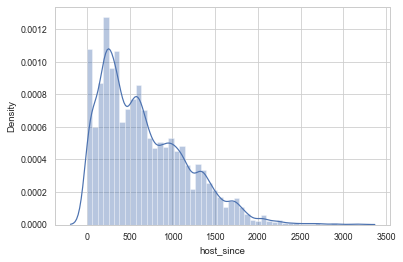

In [35]:
# host_since
sns.set(context = 'paper', style = "whitegrid")
sns.distplot(data9.host_since)

* The majority of the property has been registered the last 3 years, which aligns with the fact that Airbnb entered the China market in 2017.  

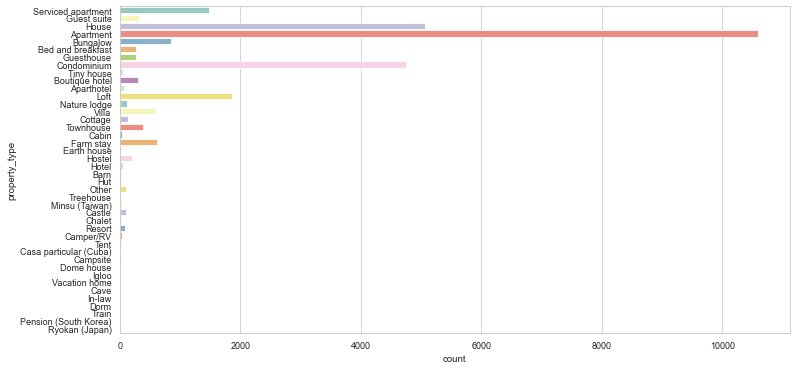

In [36]:
# property_type
fig = plt.figure(figsize = (12,6))
ax = fig.add_subplot(1,1,1)
ax = sns.countplot(y='property_type', palette = "Set3", data = data9)
ax.tick_params(labelsize = 9)

We can see from the plot that the apartment makes up the most of the properties. In addition, house and condom constitutes a big portion too.

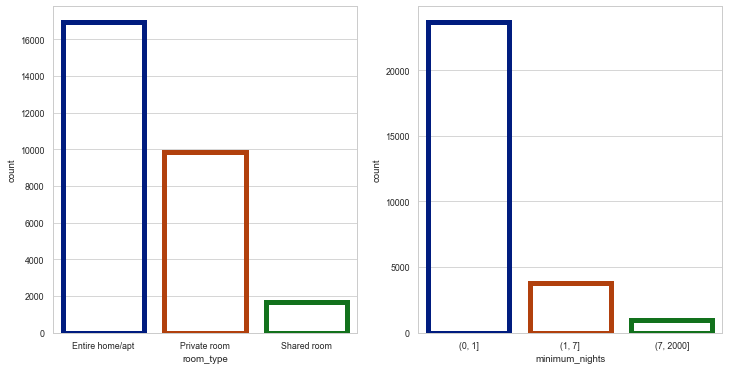

In [37]:
# room_type
fig = plt.figure(figsize = (12,6))
ax1 = fig.add_subplot(1,2,1)
ax1 = sns.countplot(x = 'room_type', data = data9, facecolor=(0, 0, 0, 0),
                    linewidth = 5, edgecolor = sns.color_palette("dark", 3))
# minimum_nights
data9['minimum_nights'].unique()
bins = [0,1,7,2000]
df = pd.cut(data9['minimum_nights'], bins)
ax2 = fig.add_subplot(1,2,2)
ax2 = sns.countplot(x = df, facecolor=(0, 0, 0, 0), linewidth = 5,
                    edgecolor = sns.color_palette("dark", 3))

* For the short rental market in Beijing, there are 3 main room types: entire home, private room and shared room. The rent of entire home ranks No.1, followed by private room and shared room.
* Most of the tenants stay 1 night.

<Figure size 1080x504 with 0 Axes>

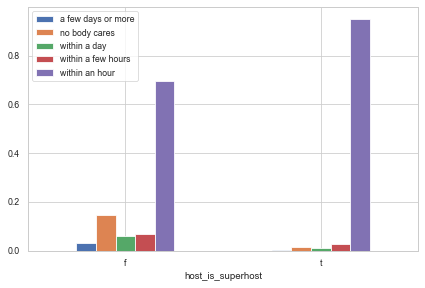

In [38]:
# the time it took the host to response
tab1 = pd.crosstab(data9['host_is_superhost'], data9['host_response_time'])
tab1_std = tab1.div(tab1.sum(1), axis = 0)

plt.figure(figsize = (15,7))
tab1_std.plot.bar()
plt.tight_layout()
plt.xticks(rotation = 0)
plt.legend(loc = 'upper left')
plt.show()

The above plot shows the distribution of response time among superhosts and non-superhosts. It's noticeable that regardless of host type, the majority of hosts can reply within an hour. The proportion that superhosts response within an hour is signicantly higher than non-superhosts. In addtion, non-superhosts getting more "nobody cares" than superhosts is a clear sign that hosts that are titled as superhost are more attractive to tenants.

#### 3.2 Airbnb in Beijing

3.2.1 how long hosts have been signed up vs different districts in Beijing

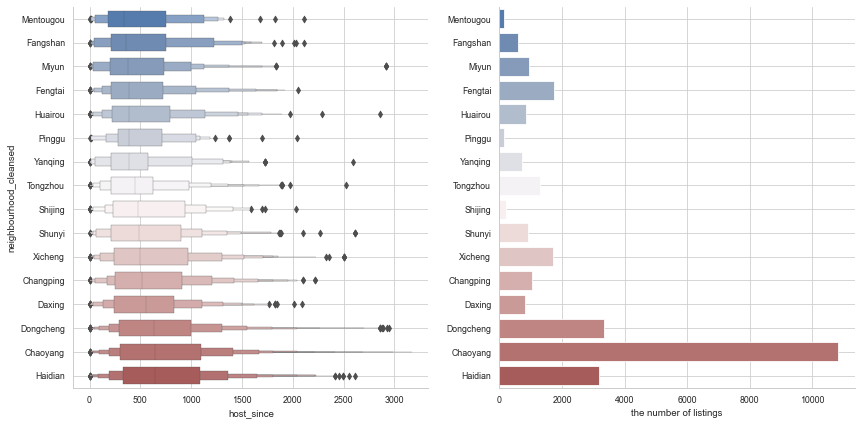

In [43]:
my_order = data9.groupby(by = ["neighbourhood_cleansed"])["host_since"].median().sort_values().index 
counts = data9['neighbourhood_cleansed'].value_counts()
sns.set(context = 'paper', style = "whitegrid")
fig = plt.figure(figsize = (14, 7))
ax1 = fig.add_subplot(1,2,1)
ax1 = sns.boxenplot(x = 'host_since', y = 'neighbourhood_cleansed', data = data9, palette = "vlag", orient = 'h',
                   linewidth = 0.3, width = 0.7, order = my_order)
ax1.grid(True)
ax2 = fig.add_subplot(1,2,2)
ax2 = sns.barplot(x = counts.values, y = counts.index,
                  palette = "vlag", orient = 'h', order = my_order)
ax2.set_xlabel('the number of listings')
ax2.grid(True)
sns.despine(trim = False, right = True)

The short rental market in Haidian, Chaoyang and Dongcheng districts started earlier than other districts, and the number of listings in the 3 districts are noticeabley more than other districts. In the suburb of the city, like Mengtougou, Fangshan and Miyun, the market only started within the last 2 years and the number of listings are much fewer. 

<Figure size 1080x504 with 0 Axes>

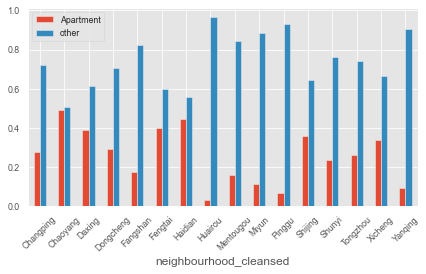

In [46]:
# why there are plenty of listings in Chaoyang District
data_1 = data9.copy()
data_1.property_type = data_1.property_type.apply(lambda x:'Apartment' if x == 'Apartment' else 'other')
plt.style.use('ggplot')

area_type = pd.crosstab(data_1['neighbourhood_cleansed'], data_1['property_type'])
area_type_std = area_type.div(area_type.sum(1), axis = 0)

plt.figure(figsize = (15,7))
area_type_std.plot.bar()
plt.tight_layout()
plt.xticks(rotation = 45)
plt.legend(loc = 'best')
plt.show()

3.2.2 room type vs location

<Figure size 720x504 with 0 Axes>

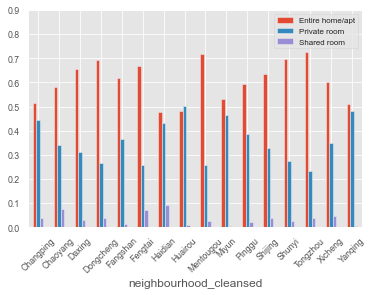

In [53]:
plt.style.use('ggplot')

area_room = pd.crosstab(data_1['neighbourhood_cleansed'], data_1['room_type'])
area_room_std = area_room.div(area_room.sum(1), axis = 0)
fig = plt.figure(figsize = (10, 7))
area_room_std.plot.bar()
plt.xticks(rotation = 45)
plt.ylim(ymin = 0, ymax = 0.9)
plt.legend(loc = 'best', fontsize = 8)
plt.show()

Different districts have different combinaions of room types. As  the above plot shows, the majority of the room type is entire home/apt in Daxing, Dongcheng, Fangshan, Fengtai, Mengtougou, Shijingshan, Shunyi and Tongzhou. 

#### 3.3 hosts vs listings

3.3.1 hosts level vs how long ago the host registered

c:\users\wensh\pycharmprojects\dataanalysis\venv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\wensh\pycharmprojects\dataanalysis\venv\lib\site-packages\seaborn\distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
c:\users\wensh\pycharmprojects\dataanalysis\venv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg,

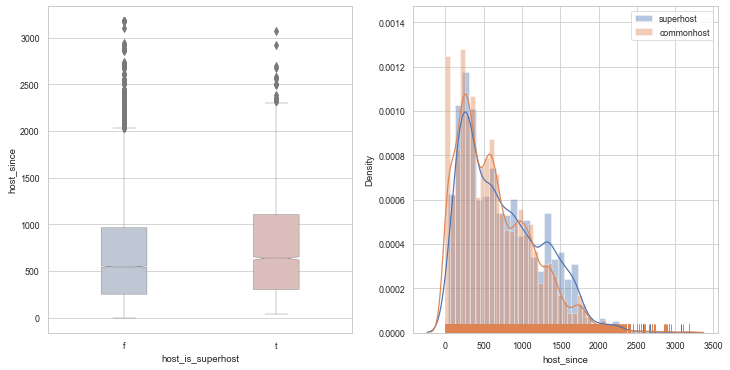

In [67]:
superhost = data_1.query("host_is_superhost == 't'")
commonhost = data_1.query("host_is_superhost == 'f'")

fig = plt.figure(figsize = (12,6))
ax1 = fig.add_subplot(1,2,1)
sns.boxplot(y = data_1.host_since, x = data_1.host_is_superhost, palette = "vlag", orient = 'v',
                      linewidth = 0.4, width = 0.3, notch = True)

ax2 = fig.add_subplot(1,2,2)
ax2 = sns.distplot(superhost.host_since, rug = True, hist = True, label = 'superhost')
ax2 = sns.distplot(commonhost.host_since, rug = True, hist = True, label = 'commonhost')
ax2.legend(loc = 'best')

Both plots show that superhosts started earlier and thus have more experience than common hosts.

3.3.2 room types

c:\users\wensh\pycharmprojects\dataanalysis\venv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\wensh\pycharmprojects\dataanalysis\venv\lib\site-packages\seaborn\distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
c:\users\wensh\pycharmprojects\dataanalysis\venv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg,

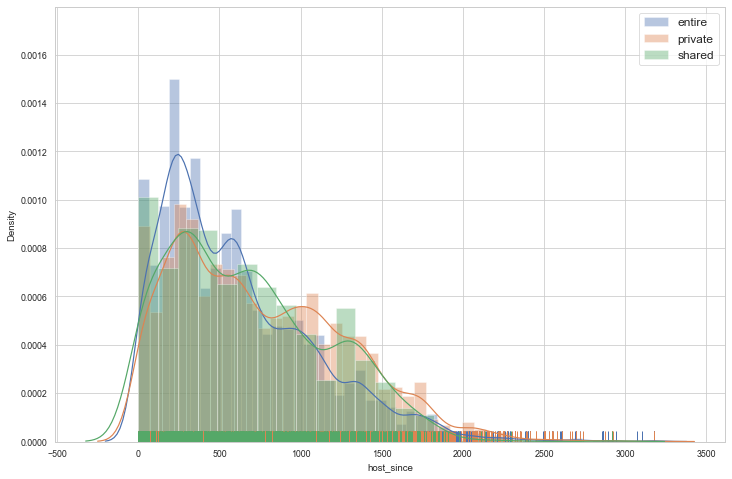

In [68]:
entire = data_1.query("room_type == 'Entire home/apt'")
private = data_1.query("room_type == 'Private room'")
shared = data_1.query("room_type == 'Shared room'")

fig = plt.figure(figsize = (12,8))

ax = fig.add_subplot(1,1,1)
ax = sns.distplot(entire.host_since, rug = True, hist = True, label = 'entire')
ax = sns.distplot(private.host_since, rug = True, hist = True, label = 'private')
ax = sns.distplot(shared.host_since, rug = True, hist = True, label = 'shared')
ax.legend(loc = 'best', fontsize = 12)

The type of entire home has the shortest history.

3.3.3 superhosts vs room type


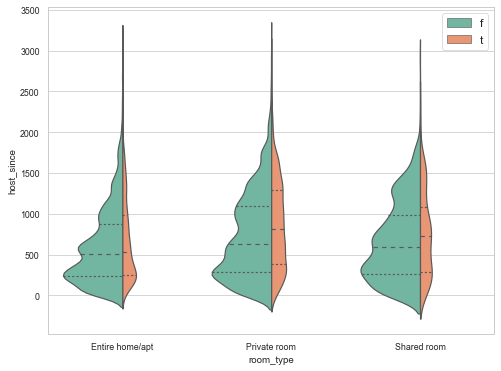

In [69]:
sns.set(context = 'paper', style = "whitegrid")
fig = plt.figure(figsize = (8,6))
ax1 = fig.add_subplot(1,1,1)
ax1 = sns.violinplot(x = "room_type", y = "host_since", hue = 'host_is_superhost',
                     data = data_1, palette = "Set2", split = True, scale = "count", inner = "quartile")
ax1.legend(loc = 'best', fontsize = 12)

* Among the 3 room types, superhosts have been on the market longer than common hosts.
* Compared to entire home and shared room, private room has enjoyed a longer history.